## Understanding the Sake Data
Now that we've scraped the data from truesake.com, let's understand it better. From their entire catalogue, there's less than 400 sakes - so not much data to play around with. Let's visualize the distribution of our data as well as the potential gaps (null or missing values).

- What % of sakes have no description or 4 words?
- What does the price/volume distribution look like?

In [183]:
import pandas as pd
import numpy as np
import json

with open('sake.json') as f:
    sakes = json.load(f)

df = pd.DataFrame(columns=[
    'NAME', 'COLLECTION','PRICE','SIZE', 
    'DESCRIPTION','DESCRIPTION_LENGTH','FOUR_WORDS','FOUR_WORDS_EXIST'
])

i = 0
for sake in sakes:
    
    row = pd.Series({
        'NAME': sake,
        'COLLECTION': sakes[sake]['collection'],
        'PRICE': sakes[sake]['price'],
        'SIZE': sakes[sake]['size'],
        'DESCRIPTION': sakes[sake]['description'],
        'DESCRIPTION_LENGTH': len(sakes[sake]['description']),
        'FOUR_WORDS': sakes[sake].get('words', None),
        'FOUR_WORDS_EXIST': 'words' in sakes[sake].keys()
    })
    df.loc[i] = row
    i+=1

def volume_to_float(volume: str) -> float:
    if "ml" == volume[-2:]:
        return float(volume.rstrip('ml'))/1000
    elif 'L' == volume[-1]:
        return float(volume.rstrip('L'))
    else:
        return np.nan

price_to_float = lambda x: float(x.replace("$",""))

df['DESCRIPTION_LENGTH'] = df['DESCRIPTION_LENGTH'].astype(int) 
df['PRICE'] = df['PRICE'].apply(price_to_float)
df['SIZE'] = df['SIZE'].apply(volume_to_float)
df['PRICE PER LITER'] = df['PRICE']/df['SIZE']
df['LN(PRICE PER LITER)'] = np.log(df['PRICE PER LITER'])
df['FOUR_WORDS_EXIST'] = df['FOUR_WORDS_EXIST'].astype('bool')

print("==========================")
print("=     Missing Values     =")
print("==========================")
print("- {} without description".format(len(df[df['DESCRIPTION_LENGTH'] == 0])))
print("- {} without four words".format(len(df[~df['FOUR_WORDS_EXIST']])))

df.sort_values(by='PRICE',ascending=False).head()

=     Missing Values     =
- 26 without description
- 131 without four words


NAME                COLLECTION  PRICE  \
139                 Dassai Junmai Daiginjo   junmai-daiginjo-daiginjo  700.0   
160      Kikuhime Kurogin 3yr Aged Daiginjo  junmai-daiginjo-daiginjo  420.0   
133  Born Yume wa Masayuma Junmai Daiginjo   junmai-daiginjo-daiginjo  267.0   
200    Tedorigawa Mangekyo Junmai Daiginjo   junmai-daiginjo-daiginjo  250.0   
218   Dassai 23 Centrifuge Junmai Daiginjo     seasonal-nama-seasonal  230.0   

     SIZE                                        DESCRIPTION  \
139  0.72  This ultra popular brewery in Japan has a huge...   
160  0.72  This sake was built to baffle and amaze sake d...   
133  1.00                                                      
200  0.72  Truly a connoisseur’s experience this one of a...   
218  0.72  The nose on this limited released New Year’s N...   

     DESCRIPTION_LENGTH                         FOUR_WORDS  FOUR_WORDS_EXIST  \
139                 778  [Smooth, Clean, Layered, Elegant]              True   
160                1147                               None             False   
133                   0                               None             False   
200                 636                               None             False   
218                 887       [New, Fresh, Silky, Festive]              True   

     PRICE PER LITER  LN(PRICE PER LITER)  
139       972.222222             6.879584  
160       583.333333             6.368759  
133       267.000000             5.587249  
200       347.222222             5.849965  
218       319.444444             5.766583

# SAKES BY COLLECTION
COLLECTION
futsushu                     3
junmai-daiginjo-daiginjo    89
junmai-ginjo                51
junmai-honjozo              76
nama                        29
nigori                      13
seasonal-nama-seasonal      51
sparkling                   11
unique                      22
Name: NAME, dtype: int64


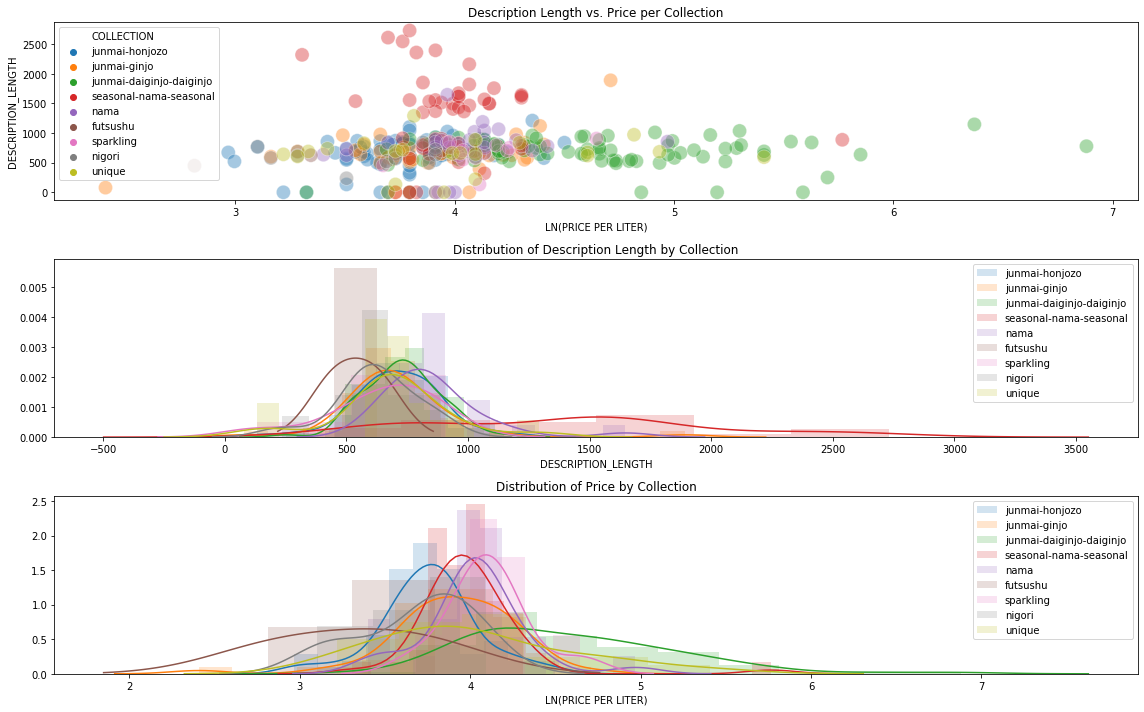

In [184]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

fig, ax = plt.subplots(3,1,figsize=(16,10))

print("# SAKES BY COLLECTION")
print("===========================")
print(df.groupby('COLLECTION').count()['NAME'])

_ = sns.scatterplot(
    data=df,
    x='LN(PRICE PER LITER)',
    y='DESCRIPTION_LENGTH',
    hue='COLLECTION',
    alpha=0.4,
    ax=ax[0],
    s=200
)
ax[0].set_title('Description Length vs. Price per Collection')

collections = [
    "junmai-honjozo",
    "junmai-ginjo",
    "junmai-daiginjo-daiginjo",
    "seasonal-nama-seasonal",
    "nama",
    "futsushu",
    "sparkling",
    "nigori",
    "unique"
]

for collection in collections:
    is_collection = df['COLLECTION'] == collection
    _ = sns.distplot(
        df[(df['DESCRIPTION_LENGTH'] > 0) & is_collection]['DESCRIPTION_LENGTH'], 
        ax=ax[1], kde=True, label=collection, hist_kws=dict(alpha=0.2),
    )
    ax[1].set_title("Distribution of Description Length by Collection")
    
    
    
    _ = sns.distplot(
        df[df['PRICE PER LITER'].notnull() & is_collection]['LN(PRICE PER LITER)'], 
        ax=ax[2], kde=True, label=collection, hist_kws=dict(alpha=0.2)
    )
    ax[2].set_title("Distribution of Price by Collection")

for axis in ax:    
    _ = axis.legend()
    
plt.tight_layout()

It's clear that Junmai Daiginjo's are more expensive, and the seasonal sakes have longer descriptions

## Further Feature Extraction

We can further determine the **BEER**/**WINE**/**FOOD** from the description field. For the Beer/Wine/Food descriptors - like the 4 word feature - we can expect a high % of missing values.


In [185]:
from typing import Dict

KEYWORDS = ['WORD', 'WINE', 'BEER', 'FOOD']

def get_keywords(description_text:str) -> Dict[str,str]:
    """
    Given text like below:
    'The brewers call this pure rice sake a Rose` Sake ...... WORD: Purple WINE: Soft reds/fat whites BEER: Creamy honey ales FOODS: Champagne fare.'
    
    Should pull out the result:
    {
        'WORD': 'Purple',
        'WINE': 'Soft reds/fat whites',
        'BEER': 'Creamy honey ales',
        'FOODS': 'Champagne fare.'
    }
    """
    SEARCH_TERMS = []
    indices = {}
    
    for KEYWORD in KEYWORDS:
        SEARCH_TERM = KEYWORD + ': '
        INDEX = description_text.find(SEARCH_TERM)
        if INDEX < 0:
            SEARCH_TERM = KEYWORD+'S: '
            INDEX = description_text.find(SEARCH_TERM)
            
        indices[KEYWORD] = INDEX
        SEARCH_TERMS.append(SEARCH_TERM)
    
    return {
        'WORD': description_text[
            indices['WORD']:indices['WINE']
        ].replace('WORD',''),
        'WINE': description_text[
            indices['WINE']:indices['BEER']
        ].replace('WINE',''),
        'BEER': description_text[
            indices['BEER']:indices['FOOD']
        ].replace('BEER',''),
        'FOOD': description_text[
            indices['FOOD']:
        ].replace('FOODS: ',''),
    }


df['WORD'], df['BEER'], df['WINE'], df['FOOD'] = ['']*4
df.head()

for i in range(len(df)):
    keywords = get_keywords(df['DESCRIPTION'].values[i])
    for WORD in KEYWORDS:
        df.loc[i,WORD] = keywords[WORD].strip().lstrip(': ')

print("NULL VALUES")
print('===========')
print( (df[['WORD', 'BEER', 'WINE', 'FOOD']] == '').sum() )

 # Remove WORD / BEER / WINE / FOOD from description now that it has been captured
df['DESCRIPTION'] = df['DESCRIPTION'].apply(lambda x: x[:x.find(' WORD:')])

df.tail()

NULL VALUES
WORD    42
BEER    43
WINE    46
FOOD    28
dtype: int64


NAME COLLECTION  PRICE  SIZE  \
340        Sawanotsuru Umeshu Koshu Jikomi     unique   29.0  0.72   
341        Tamanohikari Reishu Sake Slush      unique    8.0  0.30   
342  Tsukasabotan Yamayuzu Shibori Junmai      unique   30.0  0.72   
343             Wakatakeya A Zen Ai Koshu      unique  100.0  0.72   
344                    Yamamoto Yuzu Omoi      unique   30.0  0.50   

                                           DESCRIPTION  DESCRIPTION_LENGTH  \
340                                                                      0   
341  Yes, the packaging looks like juice boxes for ...                 606   
342  Too many sakes, not enough Beaus.Review coming...                 133   
343  This “brown rice” (milled only to 85%) aged sa...                 684   
344  Okay folks! Every once in a while it’s fun to ...                 886   

                                    FOUR_WORDS  FOUR_WORDS_EXIST  \
340                                       None             False   
341     [Semi-fruity, Refreshing, Clean, Icey]              True   
342  [Refreshing, Citrusy, Bright, Semi-sweet]              True   
343                [Smooth, Rich, Round, Full]              True   
344                 [Sweet, Fat, Citrusy, Fun]              True   

     PRICE PER LITER  LN(PRICE PER LITER)       WORD              BEER  \
340        40.277778             3.695800                                
341        26.666667             3.283414  Juice Box   Pilsners/Ambers   
342        41.666667             3.729701                                
343       138.888889             4.933674       Soft      Big Belgians   
344        60.000000             4.094345       Yuzu  Citrus pale ales   

                       WINE                                               FOOD  
340                                                                             
341      Dry Whites/Merlots  Grilled eggplant, smoked fish, stir-friend shr...  
342                                                                          !  
343  Red and White Burgundy  Smoked meats and cheeses, large pasta dishes, ...  
344             Sweet wines                        Desert foods, fruit salads.

## Bag of Words Model

Let's cluster sake by the similarity of their descriptions to each other. We can create a vector of tokens for each sake.

In [186]:
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_documents

corp = preprocess_documents(df['DESCRIPTION'])

print("We'll be transforming descriptions like this:\n")
print(df['DESCRIPTION'][2])
print("\nto this:\n")
print(corp[2])

corpus = Dictionary(corp)

print("\nUsing this corpus of words:\n")
print(corpus)

We'll be transforming descriptions like this:

This Junmai has a plum nose with subtle grass tones. The first sip has a fairly dry start filled with hints of lemon, plum, and grape skin tones. The viscosity is slick and shimmering and the overall feel is soft and balanced. This Junmai is a classic "three sipper" which means you need to realize three sips to find the soul and beauty of this semi-dry Junmai.

to this:

['junmai', 'plum', 'nose', 'subtl', 'grass', 'tone', 'sip', 'fairli', 'dry', 'start', 'fill', 'hint', 'lemon', 'plum', 'grape', 'skin', 'tone', 'viscos', 'slick', 'shimmer', 'overal', 'feel', 'soft', 'balanc', 'junmai', 'classic', 'sipper', 'mean', 'need', 'realiz', 'sip', 'soul', 'beauti', 'semi', 'dry', 'junmai']

Using this corpus of words:

Dictionary(2307 unique tokens: ['actual', 'appeal', 'aroma', 'beg', 'bodi']...)


In [267]:
from gensim.models import TfidfModel
from sklearn.manifold import TSNE
import numpy as np
import plotly.express as px

corpus_bow = [dct.doc2bow(line) for line in corp]
model = TfidfModel(corpus_bow)

num_features = max([tup[0]  for doc in corpus_bow if len(doc) > 0 for tup in doc]) + 1
bow_matrix = np.zeros((len(df),num_features))

for i in range(len(corpus_bow)):
    for index, value in model[corpus_bow[i]]:
        bow_matrix[i, index] = value

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(bow_matrix)

df['TSNE X'] = new_values[:,0]
df['TSNE Y'] = new_values[:,1]

fig = px.scatter(
    df, 
    x= 'TSNE X',
    y= 'TSNE Y',
    color= 'COLLECTION',
    hover_name= 'NAME',
    hover_data= ['FOUR_WORDS', 'WORD','BEER', 'WINE', 'FOOD'],
    opacity=0.5,
    size='DESCRIPTION_LENGTH',
    title='Visualization of Sake Descriptions'
)

fig.update_xaxes(showgrid=False, zeroline=False, showticklabels=False)
fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False)


fig.show()

In [279]:
import json
import operator
import plotly.graph_objects as go
from gensim.similarities import SparseTermSimilarityMatrix

index = SparseMatrixSimilarity(corpus_bow, num_features=num_features)

similarity_matrix = np.zeros((len(corpus_bow),len(corpus_bow)))
sorted_similarity_matrix = np.zeros((len(corpus_bow),len(corpus_bow)))

sort_order = index.get_similarities(corpus_bow[0])
order_indices = np.argsort(sort_order)[::-1]

for i in range(len(corpus_bow)):
    similarities = index.get_similarities(corpus_bow[order_indices[i]])
    sorted_similarity_matrix[i] = similarities[order_indices]
    
    similarity_matrix[i] = index.get_similarities(corpus_bow[i])
    similarities_top10_indices = sorted(range(len(similarity_matrix[i])), key=lambda j: similarity_matrix[i,j], reverse=True)[:10]
    df.loc[i, 'TOP 10 INDICES'] = json.dumps(similarities_top10_indices)
    df.loc[i, 'TOP 10'] = json.dumps([df.loc[ind, 'NAME'] for ind in similarities_top10_indices])

zipped_pairs = set(zip(df['NAME'], order_indices))
sorted_sakes = [a for a, _ in sorted(zipped_pairs, key=operator.itemgetter(1))]

fig = go.Figure(data=go.Heatmap(
    z=np.sqrt(sorted_similarity_matrix), 
    x=sorted_sakes,
    y=sorted_sakes
))

fig.update_layout(
    title=go.layout.Title(
        text="Similarity Matrix",
        xref="paper",
        x=0
    )
)

fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)

fig.show()

In [280]:
df

NAME      COLLECTION  PRICE  \
0                         Akashi-Tai Tokubetsu Honjozo  junmai-honjozo   37.0   
1                                     Akishika Junmai   junmai-honjozo    8.0   
2                  Akitabare Koshiki Junzukuri Junmai   junmai-honjozo   28.0   
3                   Amabuki Yamahai Junmai Omachi Cup   junmai-honjozo    7.0   
4                          Asamurasake Junmai Red Rice  junmai-honjozo   34.0   
5       Bunraku Nihonjin No Wasuremono Yamahai Junmai   junmai-honjozo   18.0   
6                                    Dewatsuru Junmai   junmai-honjozo   24.0   
7                              Dewatsuru Kimoto Junmai  junmai-honjozo   32.0   
8                         ENTER.SAKE Black Dot Honjozo  junmai-honjozo    9.0   
9                             ENTER.SAKE Sookuu Junmai  junmai-honjozo   45.0   
10                        Fuku Chitose Yamahai Junmai   junmai-honjozo   34.0   
11                                   Gekkeikan Ace Cup  junmai-honjozo    5.0   
12                          Genbei Onikoroshi Honjozo   junmai-honjozo   35.0   
13                                   Gozenshu 9 Junmai  junmai-honjozo   24.0   
14                                  Hakkaisan Honjozo   junmai-honjozo   26.0   
15                                HeavenSake Junmai 12  junmai-honjozo   32.0   
16   Huchuhomare Taiheikai Tokubetsu Junmai “Pacifi...  junmai-honjozo   37.0   
17               Ichinokura Mukansa Super-Dry Honjozo   junmai-honjozo   24.0   
18         Ine Mankai Junmai Genshu “Ine’s Full Bloom”  junmai-honjozo   56.0   
19                                         Izumo Fuji   junmai-honjozo   29.0   
20                                    Joppari Honjozo   junmai-honjozo    6.0   
21                                       Joto Honjozo   junmai-honjozo    5.0   
22                 Kaika Sanomaru Cup Tokubetsu Junmai  junmai-honjozo    8.0   
23                               Katafune Honjozo Cup   junmai-honjozo    7.0   
24                              Katafune Junmai Genshu  junmai-honjozo   36.0   
25               Katafune Koshino Sesshu Junmai Nigori  junmai-honjozo   31.0   
26                         Kenbishi Kuromatsu Honjozo   junmai-honjozo   40.0   
27                                        Kibo Junmai   junmai-honjozo    7.0   
28              Kirin Koshi No Takumi Tokubesu Junmai   junmai-honjozo   11.0   
29                                    Kirinzan Junmai   junmai-honjozo   36.0   
..                                                 ...             ...    ...   
315                                          Kizakura           nigori   12.0   
316                                   Kurosawa Nigori           nigori   16.0   
317                               Murai Family Genshu           nigori   30.0   
318                                     Musashino Daku          nigori   25.0   
319                                            Rihaku           nigori   36.0   
320                 Rokkasen Godanjikomi Junmai Nigori          nigori    8.0   
321                            Shirakawago Sasanigori           nigori   35.0   
322  Shirataki Nigori no Jozen Mizuno Gotoshi Junma...          nigori   43.0   
323                            Akashi-Tai Ginjo Umeshu          unique   27.0   
324                            Aragoshi Kumi no Umeshu          unique   39.0   
325                 Choryo Yoshinosugi Futsushu Taru            unique   22.0   
326     Choryo Yoshinosugi Omachi Taru Yamahai Junmai           unique   26.0   
327                                      Choya Umeshu           unique   14.0   
328                      Daruma Masamune Junmai Koshu           unique  161.0   
329                                 Hanahato Kijoushu           unique   50.0   
330                                Ichinokura Himezen           unique   30.0   
331                                   Ichinokura Taru           unique   30.0   
332                                   Ichishima Karen           unique   28.0   
